# Build a CNN classifier for P300 speller

In [2]:
# NOTE: uncomment this on Google Colab
# from google.colab import drive
# drive.mount('/content/drive')
# %cd drive/My Drive/Colab/EEGNet/
# %ls

In [3]:
# import necessary packages
## Python standard libraries
import os

## Packages for computation and modelling
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import norm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import mne
import pickle

# Packages for language model
import nltk
nltk.download('cmudict')
from nltk.corpus import cmudict

## Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Self-defined packages
from swlda import SWLDA
import eegnet_utils
import swlda_utils

# Magic command to reload packages whenever we run any later cells
%load_ext autoreload
%autoreload 2

[nltk_data] Downloading package cmudict to
[nltk_data]     /Users/zionshane/nltk_data...
[nltk_data]   Package cmudict is already up-to-date!


In [4]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


## Step 1. Data Preprocessing

In [5]:
BOARD = [["A",    "B",  "C",   "D",    "E",    "F",     "G",    "H"    ],
         ["I",    "J",  "K",   "L",    "M",    "N",     "O",    "P"    ],
         ["Q",    "R",  "S",   "T",    "U",    "V",     "W",    "X"    ],
         ["Y",    "Z",  "Sp",  "1",    "2",    "3",     "4",    "5"    ],
         ["6",    "7",  "8",   "9",    "0",    "Prd",   "Ret",  "Bs"   ],
         ["?",    ",",  ";",   "\\",   "/",    "+",     "-",    "Alt"  ],
         ["Ctrl", "=",  "Del", "Home", "UpAw", "End",   "PgUp", "Shft" ],
         ["Save", "'",  "F2",  "LfAw", "DnAw", "RtAw",  "PgDn", "Pause"],
         ["Caps", "F5", "Tab", "EC",   "Esc",  "email", "!",    "Sleep"]]
BOARD  = np.array(BOARD)
N_ROWS = BOARD.shape[0]  # number of rows
N_COLS = BOARD.shape[1]  # number of columns
M = N_ROWS * N_COLS      # the number of chars on the board

In [6]:
paradigm          = 'RC' # display paradigm ('RC', 'CB', or 'RD')
NUM_TIMESTAMPS    = 195  # number of timestamps in each window to record signals
NUM_CHANNELS      = 32   # number of eletrode channels
EEGNET_EPOCH_SIZE = 195  # size of epoch for EEGNet, we don't aggregrate this time
SWLDA_EPOCH_SIZE  = 15   # size of epoch for SWLDA, aggregate 15 timestamp/ep
NUM_TRAIN_WORDS   = 5    # number of training words for one participant
NUM_TEST_WORDS    = 5    # number of testing words for one participant
# NOTE: to make results corrected, the order in `sbj_indices` must match the order
#  of how Python read the edf file of these subjects.
sbj_indices       = ['01', '02', '03', '04', '05', '06', '07','08', '09', '10',
                     '11', '12', '13', '14', '15', '16', '17']
CORE_CHANNELS     = ('EEG_Fz', 'EEG_Cz',  'EEG_P3',  'EEG_Pz',
                     'EEG_P4', 'EEG_PO7', 'EEG_PO8', 'EEG_Oz')
NUM_CORE_CHANNELS = len(CORE_CHANNELS)  # number of core eletrodes

In [7]:
# Print path to the data directory (cite: https://stackoverflow.com/a/2860200/22322930)
directory = os.path.abspath('../../..') + '/BCI_data/EDFData-StudyD'
print(directory)

/Users/zionshane/Desktop/Duke/Research/BCI_data/EDFData-StudyD


In [8]:
train_X_list, train_Y_list, test_X_list, test_Y_list = [], [], [], []
for sbj in sbj_indices:
    sbj_directory = directory + f'/D{sbj}/SE001'
    train_data_dir = sbj_directory + '/Train/RC'
    train_features,train_response = eegnet_utils.load_data(path=train_data_dir)
    train_X_list.append(train_features)
    train_Y_list.append(train_response.reshape((-1, 1)))

    test_data_dir = sbj_directory +'/Test/Dyn'
    test_features,test_response = eegnet_utils.load_data(path=test_data_dir)
    test_X_list.append(test_features)
    test_Y_list.append(test_response.reshape((-1, 1)))

In [9]:
train_X = torch.from_numpy(np.vstack(train_X_list))
train_Y = torch.from_numpy(np.vstack(train_Y_list))
test_X  = torch.from_numpy(np.vstack(test_X_list))
test_Y  = torch.from_numpy(np.vstack(test_Y_list))

# Resize the features and responses to fit the EEGNet model
train_X = torch.from_numpy(np.expand_dims(train_X, axis=1)) # [??, 1, 32, 206]
test_X  = torch.from_numpy(np.expand_dims(test_X,  axis=1)) # [??, 1, 32, 206]

train_Y = np.squeeze(train_Y) # [??]
test_Y  = np.squeeze(test_Y)  # [??]

In [10]:
print(train_X.shape, train_Y.shape)
print(test_X.shape,  test_Y.shape)

torch.Size([104040, 1, 32, 206]) torch.Size([104040])
torch.Size([38375, 1, 32, 206]) torch.Size([38375])


In [11]:
BATCH_SIZE = 8
LR = 0.001
EPOCHS = 1

trainset, testset = TensorDataset(train_X, train_Y), TensorDataset(test_X, test_Y)
trainloader = DataLoader(dataset=trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader  = DataLoader(dataset=testset,  batch_size=BATCH_SIZE, shuffle=False)

In [12]:
alphabets = [chr(i + ord("A")) for i in range(26)]

lexicon = cmudict.dict().keys()
bigrams = []
for word in lexicon:
    word = word.upper()
    for i in range(len(word)-1):
        if (word[i].isalpha() and word[i+1].isalpha()):
            prev = word[i].upper()
            next = word[i+1].upper()
            bigrams.append((word[i], word[i+1]))

pair_freq = np.zeros(shape=(len(alphabets), len(alphabets)))

for pair in bigrams:
    prev, next = pair
    pair_freq[ord(prev) - ord('A')][ord(next) - ord('A')] += 1

pair_prob = pair_freq / pair_freq.sum(axis=1)[:, None]

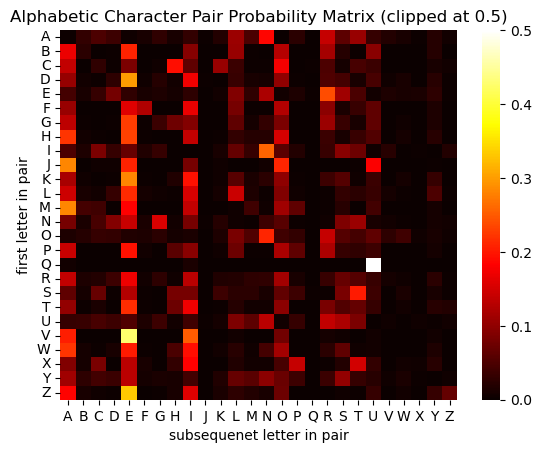

In [13]:
sns.heatmap(pair_prob, cmap='hot', vmin=0, vmax=0.5)
plt.xlabel('subsequenet letter in pair')
plt.xticks(ticks=[0.5+i for i in range(len(alphabets))], labels=alphabets, rotation=0)
plt.ylabel('first letter in pair')
plt.yticks(ticks=[0.5+i for i in range(len(alphabets))], labels=alphabets, rotation=0)
plt.title('Alphabetic Character Pair Probability Matrix (clipped at 0.5)')
plt.show()

## Step 2. Train the EEG signal classifier (binary)

### Step 2.1 Train and test the EEGNet classifier
This time, we use another dataset: `EDFData-StudyD`

In [14]:
# Construct a EEGNet instance on the correct device
eegnet_clf_D = eegnet_utils.EEGNet().to(device)

# Construct loss function object
k = 2/ (8+9-2) # target / non-target
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1, 1/k])).to(device)

# Construct optimizer
optimizer = optim.Adam(eegnet_clf_D.parameters(), lr=0.001)

try:
    model_path = './model/eegnet_model_2.pt'
    f = open(model_path, 'rb')
    eegnet_clf_D.load_state_dict(torch.load(model_path, map_location=device))
    with open('./results/history.pkl', 'rb') as f:
        history = pickle.load(f)
except:
    result = eegnet_utils.train_model(eegnet_clf_D, device, optimizer, criterion,
                                    trainloader, testloader, epochs=100)
    swlda_clf = result['model']
    history = result['history']
    with open('./results/history.pkl', 'wb') as f:
        pickle.dump(history, f)

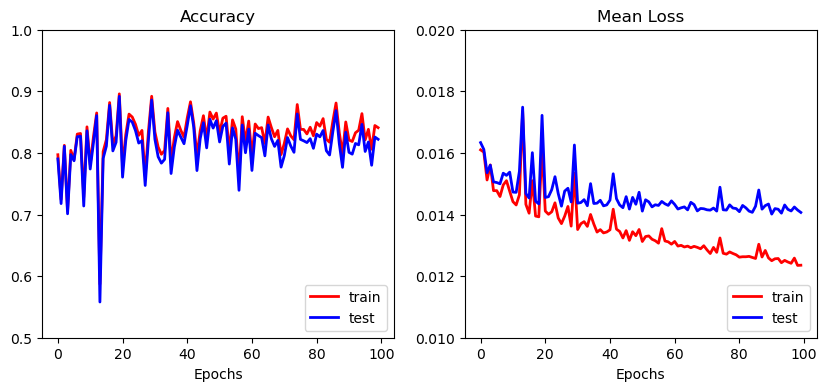

In [15]:
max_test_acc = max(history['val_acc'])
eegnet_utils.plot_acc_and_loss(history=history)

In [16]:
# Estimated time: 11min on a 2021 Macbook Air with M1 chip
eegnet_clf_test_accs = []
for sbj in sbj_indices:
    sbj_directory = directory + f'/D{sbj}/SE001'
    test_data_dir = sbj_directory +'/Test/Dyn'
    test_features,test_response = eegnet_utils.load_data(path=test_data_dir)
    test_X  = torch.from_numpy(test_features)
    test_Y  = torch.from_numpy(test_response)
    test_X  = torch.from_numpy(np.expand_dims(test_X,  axis=1))
    test_Y  = np.squeeze(test_Y)

    testset = TensorDataset(test_X, test_Y)
    BATCH_SIZE = 1
    dataloader = DataLoader(dataset=testset, batch_size=BATCH_SIZE, shuffle=False)
    test_loss, test_acc = eegnet_utils.evaluate(eegnet_clf_D, device, criterion, dataloader)
    eegnet_clf_test_accs.append(test_acc)

In [17]:
eegnet_clf_test_accs

[0.9114002478314746,
 0.9379310344827586,
 0.8905685179099573,
 0.9084468664850136,
 0.9048330842052815,
 0.8435887256847956,
 0.8872611464968153,
 0.904268545379196,
 0.911864406779661,
 0.8985936343449297,
 0.8305192064162094,
 0.9517304189435337,
 0.8874391862007961,
 0.892243623112962,
 0.8958579881656805,
 0.9354026845637584,
 0.9342650103519669]

In [18]:
avg_eegnet_clf_test_accs = sum(eegnet_clf_test_accs) / len(eegnet_clf_test_accs)

### Step 2.2 Train and test the SWLDA classifier (benchmark)

In [19]:
swlda_clf_test_accs = []

for sbj in sbj_indices:
    sbj_directory = directory + f'/D{sbj}/SE001'
    train_data_dir = sbj_directory + '/Train/RC'
    test_data_dir  = sbj_directory + '/Test/Dyn'
    train_features,train_response = swlda_utils.load_data(path=train_data_dir,
                                            num_timestamps=NUM_TIMESTAMPS,
                                            epoch_size=SWLDA_EPOCH_SIZE,
                                            num_channels=NUM_CORE_CHANNELS)
    test_features,test_response   = swlda_utils.load_data(path=test_data_dir,
                                            num_timestamps=NUM_TIMESTAMPS,
                                            epoch_size=SWLDA_EPOCH_SIZE,
                                            num_channels=NUM_CORE_CHANNELS)

    try:
        f = open(f'./model/D{sbj}-swlda-model.pkl', 'rb')
        swlda_clf = pickle.load(f)
    except:
        swlda_clf = SWLDA(penter=0.1, premove=0.15)
        swlda_clf.fit(train_features, train_response)
        # save the classifier as a standalone model file
        with open(f'./model/D{sbj}-swlda-model.pkl','wb') as f:
            pickle.dump(swlda_clf,f)

    pred = swlda_clf.test(test_features) > 0.5
    test_acc = sum(pred == test_response) / len(pred)
    swlda_clf_test_accs.append(test_acc)

In [20]:
swlda_clf_test_accs

[0.8903345724907064,
 0.9007957559681697,
 0.8803812027604337,
 0.8910081743869209,
 0.8834080717488789,
 0.8820960698689956,
 0.8834394904458599,
 0.886033982594281,
 0.8935593220338983,
 0.9022945965951147,
 0.8828619670747151,
 0.9143897996357013,
 0.8816895179124281,
 0.8932847475273296,
 0.8869822485207101,
 0.9018456375838926,
 0.8861283643892339]

In [21]:
avg_swlda_clf_test_accs = sum(swlda_clf_test_accs) / len(swlda_clf_test_accs)

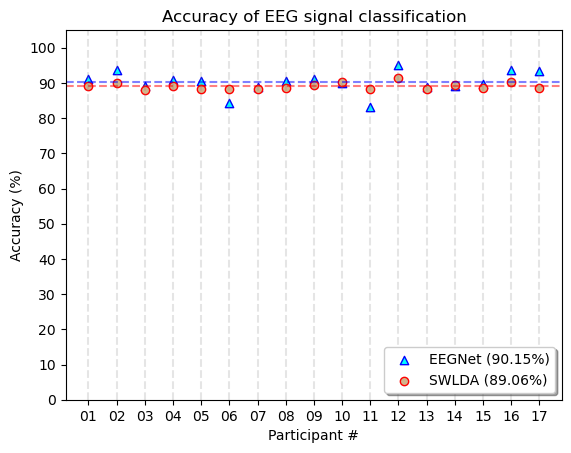

In [22]:
plt.scatter(x=[i+1 for i in range(len(sbj_indices))], y=eegnet_clf_test_accs,
            color='cyan', edgecolors='blue', marker='^',
            label=f'EEGNet ({avg_eegnet_clf_test_accs:.2%})')

plt.scatter(x=[i+1 for i in range(len(sbj_indices))], y=swlda_clf_test_accs,
            color='tan', edgecolors='red', marker='o',
            label=f'SWLDA ({avg_swlda_clf_test_accs:.2%})')
plt.axhline(y=avg_eegnet_clf_test_accs, c='blue', alpha=0.5, ls='--')
plt.axhline(y=avg_swlda_clf_test_accs,  c='red',  alpha=0.5, ls='--')
plt.xlabel('Participant #')
plt.xticks(ticks=[i+1 for i in range(len(sbj_indices))],
           labels=sbj_indices)
plt.ylabel('Accuracy (%)')
plt.ylim(0, 1+0.05)
plt.yticks([0.1*i for i in range(11)], [10*i for i in range(11)])
plt.title('Accuracy of EEG signal classification')
plt.legend(loc='lower right', fancybox=True, shadow=True, ncol=1)

for i in range(len(sbj_indices)):
    plt.axvline(x=i+1, color='gray', alpha=0.2, linestyle='--')
plt.show()

## Step 3. Evaluate the performance the two P300 speller

### Step 3.1 EEGNet + Bayesian inference

In [23]:
clf_out = eegnet_clf_D(test_X.to(device, dtype=torch.float))
scores = clf_out[:,0].exp() / (clf_out[:,0].exp() + clf_out[:,1].exp())
scores = pd.DataFrame(scores.detach().numpy(), columns=['score'])
scores['is_target'] = test_Y.detach().numpy().astype('int')
mu_1, std_1 = norm.fit(data=scores.loc[scores['is_target'] == 1]['score'])
mu_0, std_0 = norm.fit(data=scores.loc[scores['is_target'] == 0]['score'])

In [24]:
def EEGNet_speller_eval(clf):
    all_performance = []

    for sbj in sbj_indices:
        sbj_directory = directory + f'/D{sbj}/SE001'
        test_data_dir  = sbj_directory + '/Test/Dyn'
        participant_perform = []

        dir = os.fsencode(test_data_dir)
        for file in os.scandir(dir):
            test_file = os.fsdecode(file)
            raw_data = mne.io.read_raw_edf(test_file, preload=True, verbose=False)

            eeg_channels = mne.pick_channels_regexp(raw_data.info['ch_names'],'EEG')
            raw_data.notch_filter(freqs=60, picks=eeg_channels, verbose=False)
            test_epochs = eegnet_utils.get_all_epochs(raw_data)

            current_target_events=mne.find_events(raw_data,
                                                stim_channel='CurrentTarget',
                                                verbose=False)
            current_target = current_target_events[:,2]
            truth = eegnet_utils.eventIDs_to_sequence(BOARD, current_target)

            phases_events = mne.find_events(raw_data,
                                            stim_channel='PhaseInSequence',
                                            verbose=False)
            phases_appears = phases_events[:,0]
            during_trail_phases = []
            for i in range(1, len(phases_appears), 2):
                start = phases_appears[i]
                end = phases_appears[i+1]
                during_trail_phases.append((start, end))

            test_features = test_epochs.get_data(copy=False)[:,:,:NUM_TIMESTAMPS]
            stim_begin_events=mne.find_events(raw=raw_data,
                                            stim_channel='StimulusBegin',
                                            verbose=False)
            stim_begin_time = stim_begin_events[:,0]

            flashing_schedule=eegnet_utils.get_flashing_schedule(BOARD,
                                                                raw_data,
                                                                stim_begin_time)

            test_features = torch.from_numpy(np.expand_dims(test_features, axis=1))
            test_features = test_features.to(device, dtype=torch.float)
            clf_out = clf(test_features)
            clf_scores = clf_out[:,0].exp() / (clf_out[:,0].exp() + clf_out[:,1].exp())
            clf_scores = clf_scores.detach().numpy()

            NUM_SEQ = 7
            T_MAX = (N_ROWS + N_COLS) * NUM_SEQ # max number of flashes per trial
            ACTUAL_T_MAX = int(len(stim_begin_time)/len(truth))

            trail_perform = {'truth':truth, 'select':[], 'times':[]}

            for trail in range(len(during_trail_phases)):
                # NOTE: Initialize probs with LM
                if (trail_perform['select'] and trail_perform['select'][-1] in alphabets):
                    prev = trail_perform['select'][-1]
                    P_all = np.ones(shape=(N_ROWS, N_COLS)) * (1/M)
                    for letter in alphabets:
                        index = eegnet_utils.RCChar2Index(BOARD, letter)
                        loc = ((index-1) // N_COLS, (index-1) % N_COLS)
                        a = 0.9 # parameter
                        num_NAC = M - len(alphabets)
                        loc_in_pair_prob = (ord(prev)-ord('A'), ord(letter)-ord('A'))
                        bigram_prob = pair_prob[loc_in_pair_prob] * (1-num_NAC/M)
                        P_all[loc] = a * bigram_prob + (1-a) * 1/M
                else:
                    P_all = np.ones(shape=(N_ROWS, N_COLS)) * (1/M)
                num_flashes = 0
                target_index = current_target[trail]
                target_loc = ((target_index-1) // N_COLS, (target_index-1) % N_COLS)
                start, end = during_trail_phases[trail]
                time = start
                k = 0

                while time < end:
                    num_flashes += 1
                    flashed = flashing_schedule[time]
                    # Generate the classifier score
                    y = clf_scores[trail*ACTUAL_T_MAX + k]
                    # Update probabilities
                    for i in range(N_ROWS):
                        for j in range(N_COLS):
                            ch_index = N_COLS * i + j + 1
                            if (ch_index in flashed):
                                likelihood=stats.norm.pdf(x=y,loc=mu_1,scale=std_1)
                            else:
                                likelihood=stats.norm.pdf(x=y,loc=mu_0,scale=std_0)
                            P_all[i, j] = P_all[i, j] * likelihood
                    # Normalize P_all
                    P_all = P_all / P_all.sum()
                    # Check if can stop
                    k += 1
                    if trail*ACTUAL_T_MAX + k == len(stim_begin_time):
                        break
                    else:
                        time = stim_begin_time[trail*ACTUAL_T_MAX + k]

                max_loc = np.unravel_index(P_all.argmax(), P_all.shape)
                trail_perform['select'].append(BOARD[max_loc])
                trail_perform['times'].append(num_flashes)

            participant_perform.append(trail_perform)

        all_performance.append(participant_perform)

    return all_performance

In [25]:
# Estimated running time: 130min (10min/sbj) on a MacBook Pro 2019 (Intel i5)
# Estimated running time: 13min on V100 GPU + high-performance RAM (a must)

try:
    resul_path = './results/EEGNet_performance.pkl'
    f = open(resul_path, 'rb')
    EEGNet_performance = pickle.load(f)
except:
    EEGNet_performance = EEGNet_speller_eval(clf=eegnet_clf_D)
    with open('./results/EEGNet_performance.pkl', 'wb') as f:
        pickle.dump(EEGNet_performance, f)

In [ ]:
EEGNet_performance

### Step 3.2 SWLDA classifier + Bayesian inference

In [27]:
def SWLDA_speller_eval(clf):
    paradigm = 'RC'  # display paradigm ('RC', 'CB', or 'RD')
    all_performance = []

    for sbj in sbj_indices:
        participant_perform = []
        sbj_directory = directory + f'/D{sbj}/SE001'
        train_data_dir = sbj_directory + '/Train/RC'
        test_data_dir  = sbj_directory + '/Test/Dyn'
        train_features,train_response = swlda_utils.load_data(path=train_data_dir,
                                                num_timestamps=NUM_TIMESTAMPS,
                                                epoch_size=SWLDA_EPOCH_SIZE,
                                                num_channels=NUM_CORE_CHANNELS)
        test_features,test_response   = swlda_utils.load_data(path=test_data_dir,
                                            num_timestamps=NUM_TIMESTAMPS,
                                            epoch_size=SWLDA_EPOCH_SIZE,
                                            num_channels=NUM_CORE_CHANNELS)

        f = open(f'./model/D{sbj}-swlda-model.pkl', 'rb')
        clf = pickle.load(f)

        scores = pd.DataFrame(clf.test(train_features), columns=['score'])
        scores['is_target'] = train_response.astype('int')
        mu_1, std_1 = norm.fit(data=scores.loc[scores['is_target'] == 1]['score'])
        mu_0, std_0 = norm.fit(data=scores.loc[scores['is_target'] == 0]['score'])

        dir = os.fsencode(test_data_dir)
        for file in os.scandir(dir):
            test_file = os.fsdecode(file)
            raw_data = mne.io.read_raw_edf(test_file, preload=True, verbose=False)

            stim_events = mne.find_events(raw=raw_data,
                                        stim_channel='StimulusBegin',
                                        verbose=False)
            eeg_channels = mne.pick_channels_regexp(raw_data.info['ch_names'],'EEG')
            raw_data.notch_filter(freqs=60, picks=eeg_channels, verbose=False)
            test_epochs = swlda_utils.get_core_epochs(raw_data)

            current_target_events=mne.find_events(raw_data,
                                                stim_channel='CurrentTarget',
                                                verbose=False)
            current_target = current_target_events[:,2]
            truth = swlda_utils.eventIDs_to_sequence(BOARD, current_target)

            phases_events = mne.find_events(raw_data,
                                            stim_channel='PhaseInSequence',
                                            verbose=False)
            phases_appears = phases_events[:,0]
            during_trail_phases = []
            for i in range(1, len(phases_appears), 2):
                start = phases_appears[i]
                end = phases_appears[i+1]
                during_trail_phases.append((start, end))

            test_features, test_response = swlda_utils.split_data(test_epochs,
                                                    n_channels=NUM_CORE_CHANNELS,
                                                    n_times=NUM_TIMESTAMPS,
                                                    n_samples=SWLDA_EPOCH_SIZE)
            stim_begin_events=mne.find_events(raw=raw_data,
                                            stim_channel='StimulusBegin',
                                            verbose=False)
            stim_begin_time = stim_begin_events[:,0]

            flashing_schedule=swlda_utils.get_flashing_schedule(BOARD,
                                                              raw_data,
                                                              stim_begin_time)

            clf_scores = clf.test(data=test_features)

            NUM_SEQ = 7
            T_MAX = (N_ROWS + N_COLS) * NUM_SEQ # max number of flashes per trial
            ACTUAL_T_MAX = int(len(stim_begin_time)/len(truth))
            P_threshold = 0.9

            trail_perform = {'truth':truth, 'select':[], 'times':[]}

            for trail in range(len(during_trail_phases)):
                # NOTE: Initialize probs with LM
                if (trail_perform['select'] and trail_perform['select'][-1] in alphabets):
                    prev = trail_perform['select'][-1]
                    P_all = np.ones(shape=(N_ROWS, N_COLS)) * (1/M)
                    for letter in alphabets:
                        index = swlda_utils.RCChar2Index(BOARD, letter)
                        loc = ((index-1) // N_COLS, (index-1) % N_COLS)
                        a = 0.9 # parameter
                        num_NAC = M - len(alphabets)
                        loc_in_pair_prob = (ord(prev)-ord('A'), ord(letter)-ord('A'))
                        bigram_prob = pair_prob[loc_in_pair_prob] * (1-num_NAC/M)
                        P_all[loc] = a * bigram_prob + (1-a) * 1/M
                else:
                    P_all = np.ones(shape=(N_ROWS, N_COLS)) * (1/M)
                num_flashes = 0
                target_index = current_target[trail]
                target_loc = ((target_index-1) // N_COLS, (target_index-1) % N_COLS)
                start, end = during_trail_phases[trail]
                time = start
                k = 0

                while time < end:
                    num_flashes += 1
                    flashed = flashing_schedule[time]
                    # Generate the classifier score
                    y = clf_scores[trail*ACTUAL_T_MAX + k]
                    # Update probabilities
                    for i in range(N_ROWS):
                        for j in range(N_COLS):
                            ch_index = N_COLS * i + j + 1
                            if (ch_index in flashed):
                                likelihood=stats.norm.pdf(x=y,loc=mu_1,scale=std_1)
                            else:
                                likelihood=stats.norm.pdf(x=y,loc=mu_0,scale=std_0)
                            P_all[i, j] = P_all[i, j] * likelihood
                    # Normalize P_all
                    P_all = P_all / P_all.sum()
                    # Check if can stop
                    k += 1
                    if trail*ACTUAL_T_MAX + k == len(stim_begin_time):
                        break
                    else:
                        time = stim_begin_time[trail*ACTUAL_T_MAX + k]

                max_loc = np.unravel_index(P_all.argmax(), P_all.shape)
                trail_perform['select'].append(BOARD[max_loc])
                trail_perform['times'].append(num_flashes)

            participant_perform.append(trail_perform)

        all_performance.append(participant_perform)

    return all_performance

In [28]:
# Estimated time: 6min on a 2020 Macbook Pro with Intel i5 CPU
try:
    resul_path = './results/SWLDA_performance.pkl'
    f = open(resul_path, 'rb')
    SWLDA_performance = pickle.load(f)
except:
    SWLDA_performance = SWLDA_speller_eval(clf=swlda_clf)
    with open('./results/SWLDA_performance.pkl', 'wb') as f:
        pickle.dump(SWLDA_performance, f)

### Visualization

In [29]:
def count_num_same(list_1, list):
    if (len(list_1) != len(list)):
        raise ValueError('The two input lists should have the same length!')
    num_same = 0
    for i in range(len(list_1)):
        if (list_1[i] == list[i]):
            num_same += 1

    return num_same

In [30]:
EEGNet_accuracies = []
EEGNet_trails = []
for participant_perform in EEGNet_performance:
    detailed_trails = [] # for each character
    num_correct = 0
    num_all = 0
    for trail_perform in participant_perform:
        truth  = trail_perform['truth']
        select = trail_perform['select']
        times  = trail_perform['times']
        num_all += len(truth)
        num_correct += count_num_same(truth, select)
        detailed_trails += times
    accuracy = num_correct / num_all
    EEGNet_accuracies.append(accuracy)
    EEGNet_trails.append(detailed_trails)
EEGNet_accuracies_df = pd.DataFrame({'index': sbj_indices,
                                     'accuracy': EEGNet_accuracies})
avg_EEGNet_accuracies = EEGNet_accuracies_df['accuracy'].mean()

In [31]:
SWLDA_accuracies = []
SWLDA_trails = []
for participant_perform in SWLDA_performance:
    detailed_trails = [] # for each character
    num_correct = 0
    num_all = 0
    for trail_perform in participant_perform:
        truth  = trail_perform['truth']
        select = trail_perform['select']
        times  = trail_perform['times']
        num_all += len(truth)
        num_correct += count_num_same(truth, select)
        detailed_trails += times
    accuracy = num_correct / num_all
    SWLDA_accuracies.append(accuracy)
    SWLDA_trails.append(detailed_trails)
SWLDA_accuracies_df = pd.DataFrame({'index': sbj_indices,
                                    'accuracy': SWLDA_accuracies})
avg_SWLDA_accuracies = SWLDA_accuracies_df['accuracy'].mean()

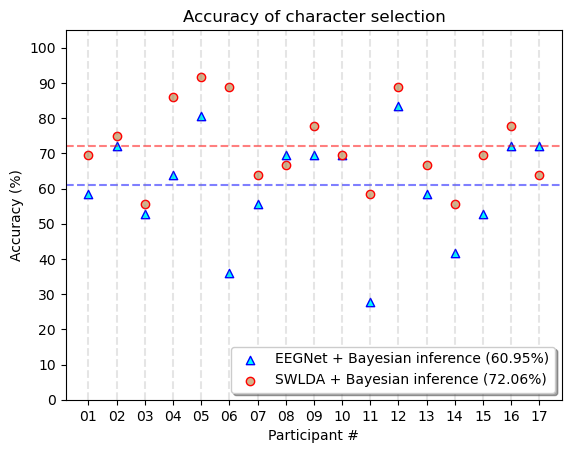

In [32]:
plt.scatter(x=[i+1 for i in range(len(sbj_indices))],
            y=EEGNet_accuracies_df['accuracy'],
            color='cyan', edgecolors='blue', marker='^',
            label=f'EEGNet + Bayesian inference ({avg_EEGNet_accuracies:.2%})')

plt.scatter(x=[i+1 for i in range(len(sbj_indices))],
            y=SWLDA_accuracies_df['accuracy'],
            color='tan', edgecolors='red', marker='o',
            label=f'SWLDA + Bayesian inference ({avg_SWLDA_accuracies:.2%})')
plt.axhline(y=EEGNet_accuracies_df['accuracy'].mean(), c='blue', alpha=0.5, ls='--')
plt.axhline(y=SWLDA_accuracies_df['accuracy'].mean(), c='red',  alpha=0.5, ls='--')
plt.xlabel('Participant #')
plt.xticks(ticks=[i+1 for i in range(len(sbj_indices))],
           labels=SWLDA_accuracies_df['index'])
plt.ylabel('Accuracy (%)')
plt.ylim(0, 1+0.05)
plt.yticks([0.1*i for i in range(11)], [10*i for i in range(11)])
plt.title('Accuracy of character selection')
plt.legend(loc='lower right', fancybox=True, shadow=True, ncol=1)

for i in range(len(sbj_indices)):
    plt.axvline(x=i+1, color='gray', alpha=0.2, linestyle='--')
plt.show()